# Análise dos dados fornecidos para fazer previsões de possíveis partidas de futebol

Dados carregados com sucesso!

--- Valores ausentes após tratamento ---
Chutes a gol 1         0
Chutes a gol 2         0
Impedimentos 1         0
Impedimentos 2         0
Escanteios 1           0
Escanteios 2           0
Chutes fora 1          0
Chutes fora 2          0
Faltas 1               0
Faltas 2               0
Cartões amarelos 1     0
Cartões amarelos 2     0
Cartões vermelhos 1    0
Cartões vermelhos 2    0
Cruzamentos 1          0
Cruzamentos 2          0
Laterais 1             0
Laterais 2             0
Chutes bloqueados 1    0
Chutes bloqueados 2    0
Contra-ataques 1       0
Contra-ataques 2       0
Gols 1                 0
Gols 2                 0
Tiro de meta 1         0
Tiro de meta 2         0
Tratamentos 1          0
Tratamentos 2          0
Substituições 1        0
Substituições 2        0
Tiros-livres 1         0
Tiros-livres 2         0
Defesas difíceis 1     0
Defesas difíceis 2     0
Posse 1(%)             0
Posse 2(%)             0
Time 1                 0
Tim

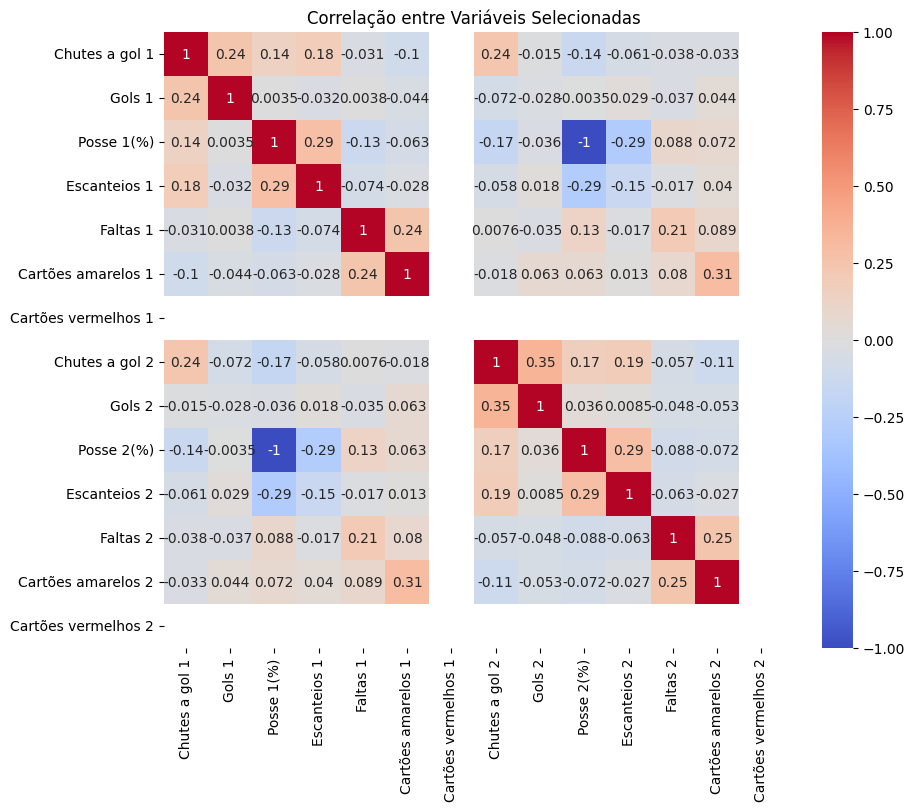

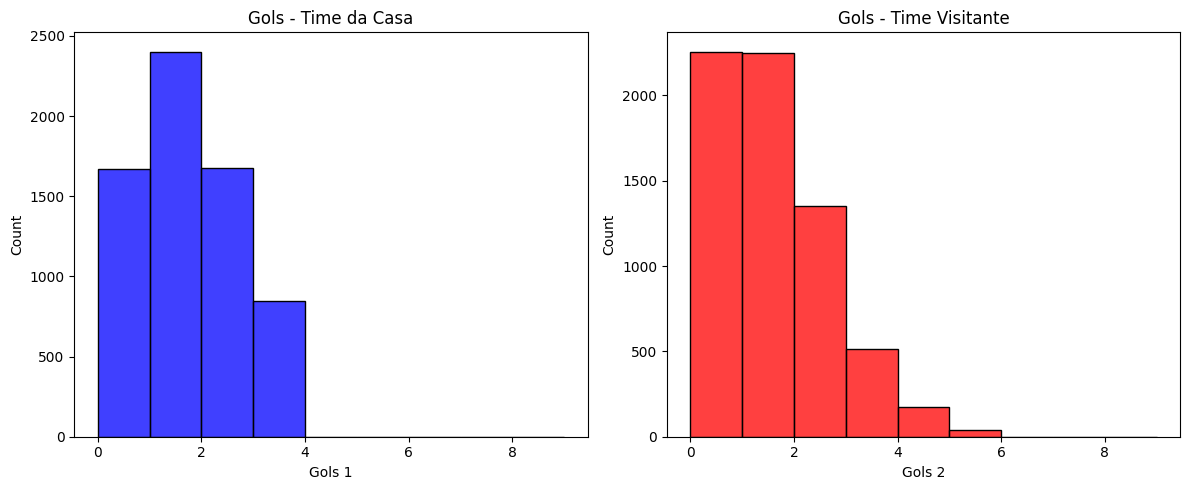

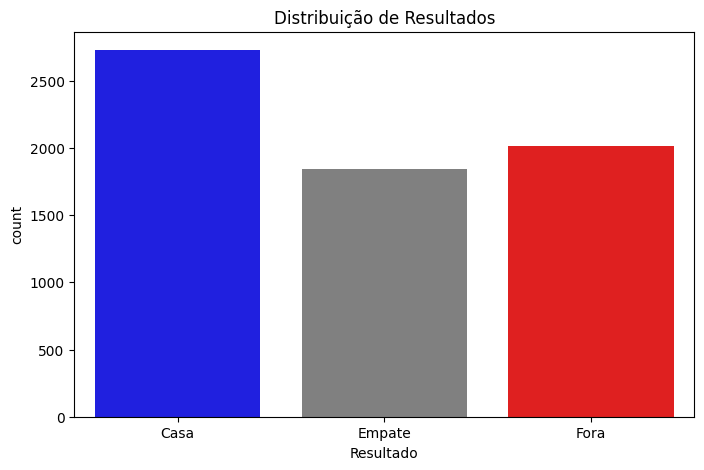


Relatório de Classificação:
              precision    recall  f1-score   support

        Casa       1.00      1.00      1.00       536
      Empate       1.00      1.00      1.00       389
        Fora       1.00      1.00      1.00       394

    accuracy                           1.00      1319
   macro avg       1.00      1.00      1.00      1319
weighted avg       1.00      1.00      1.00      1319

Acurácia: 0.9992418498862775


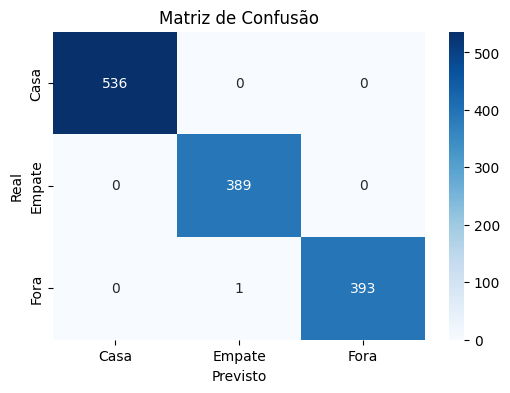


A análise foi salva como 'modelo_previsao_futebol.pkl'


In [5]:
#  Análise e Previsão de Resultados de Partidas de Futebol

#importar as bibliotecas que usaremos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib

# 1. Carregar os dados

try:
    df = pd.read_csv("campeonatos_futebol_atualizacao.csv")
    print("Dados carregados com sucesso!")
except FileNotFoundError:
    exit("Arquivo não encontrado. Verifique o caminho.")#raise FileNotFoundError("Arquivo não encontrado. Verifique o caminho.") estavamos utilizando o jupiter notebook, esse código é para localizar o linha do erro que estava acontecendo


# 2. Tratamento de Dados

# Tratamento de NaN (exemplo: preencher com mediana para numéricas e moda para categóricas)
# Preencher valores ausentes
for col in df.select_dtypes(include=['float64', 'int64']):
    df[col] = df[col].fillna(df[col].median()) # Preenche numéricas com mediana
    
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].fillna(df[col].mode()[0])# Preenche categóricas com moda

print("\n--- Valores ausentes após tratamento ---")
print(df.isnull().sum())  # Deve mostrar 0 NaN

# Detectar colunas numéricas automaticamente
cols_numericas = df.select_dtypes(include=['int64', 'float64']).columns

# Função para encontrar índices com outliers usando IQR e remove-los
def get_outlier_indices(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)].index


# Coletar todos os índices de outliers
outlier_indices = set()
for col in cols_numericas:
    indices = get_outlier_indices(df, col)
    outlier_indices.update(indices)
    
# Remover apenas uma vez
print(f"Número de linhas removidas por outliers: {len(outlier_indices)}")
df = df.drop(index=outlier_indices).reset_index(drop=True)

print("Outliers removidos de todas as colunas numéricas usando IQR!")




# 3. Primeira inspeção
print("\n--- Primeiras linhas do DataFrame ---")
print(df.head())

print("\n--- Informações das colunas ---")
print(df.info())

#4. Verificar colunas numéricas para a matriz de correlação
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nColunas numéricas disponíveis:", colunas_numericas)

#5. Matriz de correlação apenas com colunas numéricas existentes

# Variáveis Selecionadas
cols = ['Chutes a gol 1', 'Gols 1', 'Posse 1(%)', 'Escanteios 1', 
             'Faltas 1', 'Cartões amarelos 1', 'Cartões vermelhos 1',
             'Chutes a gol 2', 'Gols 2', 'Posse 2(%)', 'Escanteios 2', 
             'Faltas 2', 'Cartões amarelos 2', 'Cartões vermelhos 2']

# Correlação
plt.figure(figsize=(10,8))
sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis Selecionadas")
plt.show()

# Distribuição de gols
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['Gols 1'], bins=range(0,10), color='blue').set_title('Gols - Time da Casa')
plt.subplot(1,2,2)
sns.histplot(df['Gols 2'], bins=range(0,10), color='red').set_title('Gols - Time Visitante')
plt.tight_layout()
plt.show()

# Criar coluna Resultado

df['Resultado'] = df.apply(lambda x: 'Casa' if x['Gols 1'] > x['Gols 2'] else ('Empate' if x['Gols 1'] == x['Gols 2'] else 'Fora'), axis=1)

# Gráfico de resultados
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Resultado', hue='Resultado', order=['Casa', 'Empate', 'Fora'],
              palette={'Casa':'blue', 'Empate':'gray', 'Fora':'red'}, legend=False)
plt.title('Distribuição de Resultados')
plt.show()


# 6. Machine Learning

# Features (variáveis de entrada) e Target (variável alvo)
X = df[cols]
y = df['Resultado']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar modelo de Random Forest
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Previsão
y_pred = modelo.predict(X_test)

# Avaliação do modelo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

# Matriz de confusão
cmp = confusion_matrix(y_test, y_pred, labels=['Casa', 'Empate', 'Fora'])
plt.figure(figsize=(6,4))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=['Casa', 'Empate', 'Fora'], yticklabels=['Casa', 'Empate', 'Fora'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# Salvar modelo
joblib.dump(modelo, 'modelo_previsao_futebol.pkl')
print("\nA análise foi salva como 'modelo_previsao_futebol.pkl'")
